# Exploring Singapore's food culture near major train stations

## Introduction

**Background**

Singapore's Mass Rapid Transport (MRT) is well connected is one of the main transport mode in the country. In 2019, the average daily ridership is at 3.384 million, which is about half the population of Singapore. 

Like any country, going out for food and drinks is common and is a part of the culture where people spending time catching-up with each other, or just trying out new places. Similarly, businesses are also changing, and new ones are appearing. 

**Problem area**

Singapore is a small country and business competition is high. For both business owners and customers, there are too many options to choose from, or compete against.

For this project, we will try to determine the top 10 food and drinks places located around major MRT interchanges. 

**Target Audience**

Hopefully, this observation can help new business owners understand the landscape just a little more before they startup, as well as to help customers  pick their next outing. 

**Scope**

For the purpose of this project, MRT interchanges are the main train networks that connects 2 or more other networks, and excludes those that connects to Light Rail Transits stations.

## Data

The datasets required for this analysis are:

1. List of MRT interchanges and its latitude and longitude. The source can be found in [data.world](https://data.world/hxchua/train-stations-in-singapore) and has the features required:
    1. stn_name
    2. stn_no
    3. latitude
    4. longitude
    5. color (color of the MRT network link)  
    
2. Data for busiest MRT interchanges. [mytransport.sg](http://mytransport.sg) provides monthly ridership statistics, however the data needs to be understood further before using, as it records the entry and exits of the station gantries instead of the passenger count.
3. Nearby venues from Foursquare. We will be using the `explore` API endpoint to source for venues near each of the MRT interchange

At this point, the following sources are identified:

- data.gov.sg
- mytransport.sg
- data.world
- Wikipedia
- Foursquare

## Methodology

### Import required libraries

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ("Libraries loaded")

Libraries loaded


### 1. Identifying MRT Interchanges
We'll start by taking a look at the list of MRT stations taken from the data.world source. 

In [3]:
sg_mrt_stations_all = pd.read_csv( "data/dataworld-singapore-mrt-stations.csv" )

In [4]:
sg_mrt_stations_all.head(15)

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS
5,153,BARTLEY MRT STATION,CC12,33168.3039,36108.7003,1.342828,103.879746,YELLOW
6,115,BAYFRONT MRT STATION,DT16,30867.0093,29368.6250,1.281874,103.859073,BLUE
7,115,BAYFRONT MRT STATION,CE1,30867.0093,29368.6250,1.281874,103.859073,OTHERS
8,140,BEAUTY WORLD MRT STATION,DT5,21598.1665,35931.2359,1.341223,103.775810,BLUE
9,37,BEDOK MRT STATION,EW5,38757.9520,34024.7048,1.323980,103.929959,GREEN


## Clean up the columns

In [5]:
# remove columns we don't need
sg_mrt_stations_all.drop( ['OBJECTID', 'X', 'Y' ], axis=1, inplace=True )

# rename some columns
sg_mrt_stations_all.rename( columns={ 'Latitude': 'LATITUDE', 'Longitude':'LONGITUDE' }, inplace=True)

# convert color values to lowercase
sg_mrt_stations_all['COLOR'] = sg_mrt_stations_all['COLOR'].str.lower()

sg_mrt_stations_all.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
0,ADMIRALTY MRT STATION,NS10,1.440585,103.800998,red
1,ALJUNIED MRT STATION,EW9,1.316433,103.882893,green
2,ANG MO KIO MRT STATION,NS16,1.369933,103.849553,red
3,BAKAU LRT STATION,SE3,1.388093,103.905418,others
4,BANGKIT LRT STATION,BP9,1.380018,103.772667,others


In [6]:
# check the shape
sg_mrt_stations_all.shape

(187, 5)

The data provided is structured in a way that the MRT station names that are interchanges are repeated for each train network it is connected to. We can quickly verify this:

In [7]:
sg_mrt_stations_all_grouped = sg_mrt_stations_all.loc[:].groupby('STN_NAME').count()
sg_mrt_stations_all_grouped.rename( columns = { 'STN_NO' : 'TOTAL_STNS' }, inplace=True)
sg_mrt_stations_all_grouped[ ['TOTAL_STNS'] ].sort_values( ['TOTAL_STNS'], ascending=False ).head(10)

,TOTAL_STNS
STN_NAME,
DHOBY GHAUT MRT STATION,3
BOTANIC GARDENS MRT STATION,2
SERANGOON MRT STATION,2
HARBOURFRONT MRT STATION,2
RAFFLES PLACE MRT STATION,2
CITY HALL MRT STATION,2
PROMENADE MRT STATION,2
CHINATOWN MRT STATION,2
TAMPINES MRT STATION,2


From the list above, we can check if **DHOBY GHAUT MRT STATION** is connected to **3** train network lines:

In [8]:
sg_mrt_stations_all[ sg_mrt_stations_all["STN_NAME"] == "DHOBY GHAUT MRT STATION" ]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR
51,DHOBY GHAUT MRT STATION,NS24,1.298701,103.846112,red
52,DHOBY GHAUT MRT STATION,NE6,1.299705,103.845485,purple
53,DHOBY GHAUT MRT STATION,CC1,1.298843,103.846236,yellow


We can confirm that it is indeed connected to 3 stations; **NS24**, **NE6**, and **CC1**.  

With this, we will now proceed with further cleaning and drop rows that are not interchanges.

In [9]:
# Create a dataframe of the interchange names


mrt_interchange_names = sg_mrt_stations_all_grouped.loc[:].reset_index()

# get the indexes of non-interchange stations
indexes_to_drop = mrt_interchange_names[ mrt_interchange_names['TOTAL_STNS'] == 1 ].index 

# drop them
mrt_interchange_names.drop(indexes_to_drop, inplace = True)
mrt_interchange_names.drop(['LATITUDE', 'LONGITUDE', 'COLOR'], axis=1, inplace=True)
mrt_interchange_names.reset_index(inplace=True, drop=True)

mrt_interchange_names.head()

,STN_NAME,TOTAL_STNS
0,BAYFRONT MRT STATION,2
1,BISHAN MRT STATION,2
2,BOTANIC GARDENS MRT STATION,2
3,BUGIS MRT STATION,2
4,BUONA VISTA MRT STATION,2


In [10]:

# add a column to indicate which station is an interchange
sg_mrt_stations_all['IS_INTERCHANGE'] = sg_mrt_stations_all['STN_NAME'].isin( mrt_interchange_names['STN_NAME'] )

# create a new dataframe that are interchanges
mrt_interchanges = sg_mrt_stations_all.loc[ sg_mrt_stations_all['IS_INTERCHANGE'] == True ].copy()
mrt_interchanges.reset_index(inplace=True, drop=True)
mrt_interchanges.head()

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,BAYFRONT MRT STATION,DT16,1.281874,103.859073,blue,True
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
2,BISHAN MRT STATION,CC15,1.351309,103.849150,yellow,True
3,BISHAN MRT STATION,NS17,1.350839,103.848140,red,True
4,BOTANIC GARDENS MRT STATION,DT9,1.322424,103.816136,blue,True


In [11]:
mrt_interchanges

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,BAYFRONT MRT STATION,DT16,1.281874,103.859073,blue,True
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
2,BISHAN MRT STATION,CC15,1.351309,103.849150,yellow,True
3,BISHAN MRT STATION,NS17,1.350839,103.848140,red,True
4,BOTANIC GARDENS MRT STATION,DT9,1.322424,103.816136,blue,True
5,BOTANIC GARDENS MRT STATION,CC19,1.322110,103.814988,yellow,True
6,BUGIS MRT STATION,DT14,1.299551,103.856862,blue,True
7,BUGIS MRT STATION,EW12,1.300465,103.855701,green,True
8,BUONA VISTA MRT STATION,EW21,1.307183,103.790203,green,True
9,BUONA VISTA MRT STATION,CC22,1.306492,103.790665,yellow,True


The provided data contains a **'COLOR'** column which corresponds to color assigned to the train network line. We note that there are colors assigned as 'Others':

In [12]:
mrt_interchanges[ mrt_interchanges['COLOR'] == 'others' ]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,others,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,others,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,others,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,others,True


We will correct these values manually as it is faster that to do so. Color references can be checked here: https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations#MRT_stations

In [13]:
# Update using the indexes from the table above
mrt_interchanges.loc[1, 'COLOR'] = 'yellow'
mrt_interchanges.loc[17, 'COLOR'] = 'green'
mrt_interchanges.loc[28, 'COLOR'] = 'yellow'
mrt_interchanges.loc[44, 'COLOR'] = 'brown'


# let's check the values again
mrt_interchanges.loc[[1, 17, 28, 44]]

,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
1,BAYFRONT MRT STATION,CE1,1.281874,103.859073,yellow,True
17,EXPO MRT STATION,CG1,1.334550,103.961513,green,True
28,MARINA BAY MRT STATION,CE2,1.276151,103.855089,yellow,True
44,WOODLANDS MRT STATION,TE2,1.436067,103.787945,brown,True


Now we will plot these on a map to visulize their positions.

In [14]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore is 1.3408630000000001, 103.83039182212079.


In [15]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label, color in zip(mrt_interchanges['LATITUDE'], mrt_interchanges['LONGITUDE'], mrt_interchanges['STN_NAME'] + "(" + mrt_interchanges['STN_NO'] + ")", mrt_interchanges['COLOR'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

We have now plotted the stations on each interchange, however, we are more concerned with the general area of these interchanges. Let's clean up the data little further but grouping the data by interchange name and using the `mean` for its latitude and longitude

In [16]:
    
mean_coords = mrt_interchanges.copy()
mean_coords.drop(['STN_NO', 'COLOR'], axis=1, inplace=True )
mean_coords = mean_coords.groupby('STN_NAME').mean()
mean_coords.reset_index(inplace=True)
# print(mean_coords.shape)
# print( mean_coords[ mean_coords['STN_NAME'] == 'BISHAN MRT STATION'] )

current_station = ''

mrt_interchanges_mean = pd.DataFrame(columns=['STN_NAME', 'MEAN_LATITUDE', 'MEAN_LONGITUDE'] ).copy()

for index, row in mrt_interchanges.iterrows():
    
    if( current_station != row['STN_NAME'] ):
        
        if(current_station != ''):
            mrt_interchanges_mean = mrt_interchanges_mean.append({
                'STN_NAME': current_station, 
                'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
                'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
            }, ignore_index=True)
        
        current_station = row['STN_NAME']
#         print(current_station)
        

# save the last data    
mrt_interchanges_mean = mrt_interchanges_mean.append({
    'STN_NAME': current_station, 
    'MEAN_LATITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LATITUDE'].iloc[0],
    'MEAN_LONGITUDE': mean_coords[ mean_coords['STN_NAME'] == current_station]['LONGITUDE'].iloc[0]
}, ignore_index=True)

# check that we have the same number of rows
mean_coords.shape[0] == mrt_interchanges_mean.shape[0]

True

Check again how many interchanges we have

In [17]:
mrt_interchanges_mean.shape

(22, 3)

In [18]:
mrt_interchanges_mean.head()

,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,BAYFRONT MRT STATION,1.281874,103.859073
1,BISHAN MRT STATION,1.351074,103.848645
2,BOTANIC GARDENS MRT STATION,1.322267,103.815562
3,BUGIS MRT STATION,1.300008,103.856281
4,BUONA VISTA MRT STATION,1.306838,103.790434


In [19]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')


# add markers to map
for lat, lng, label in zip(mrt_interchanges_mean['MEAN_LATITUDE'], mrt_interchanges_mean['MEAN_LONGITUDE'], mrt_interchanges_mean['STN_NAME'] ):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
    
map

### Now we have plotted a map showing the 22 MRT interchanges in Singapore. Next we will figure out which of these are the most busiest

## 2. Exploring the busiest interchanges  

The data we are using is provided by Singapore's Land Trasport Authority. We will be using the data from October 2020.

### TO ADD

In [20]:
passengers_oct2020 = pd.read_csv('data/transport_node_train_202010.csv')

  
Lets examine the data

In [21]:
passengers_oct2020.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-10,WEEKDAY,11,TRAIN,NS7,2353,1912
1,2020-10,WEEKENDS/HOLIDAY,11,TRAIN,NS7,1434,1940
2,2020-10,WEEKDAY,16,TRAIN,SW4,1033,1457
3,2020-10,WEEKENDS/HOLIDAY,16,TRAIN,SW4,514,522
4,2020-10,WEEKDAY,10,TRAIN,CC5,1319,3515


The data shows the hourly (TIME_PER_HOUR) taps in and out of each station, separated by Weekdays and Weekends/Holiday. We will clean up the data now by doing a few things:
- Create a new **AVG_PASSENGERS** column as a mean of the Tap In and Tap Out values
- Drop the **Tap In** and **Tap Out** columns after calculating the mean
- Drop the **AVG_PASSENGERS** column as we know that this data is for TRAIN only. 

In [22]:
# get the mean of passengers moving through the station
passengers_oct2020['AVG_PASSENGERS'] = passengers_oct2020[['TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'] ] .mean(axis=1)

# remove columns we don't need
# passengers_oct2020.drop( ['PT_TYPE', 'TOTAL_TAP_IN_VOLUME', 'TOTAL_TAP_OUT_VOLUME'], axis=1, inplace=True )
passengers_oct2020.drop( 'PT_TYPE', axis=1, inplace=True )

In [23]:
passengers_oct2020.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2353,1912,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1434,1940,1687.0
2,2020-10,WEEKDAY,16,SW4,1033,1457,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,514,522,518.0
4,2020-10,WEEKDAY,10,CC5,1319,3515,2417.0


Interchanges in this datasets are separates by a '/' on the PT_CODE column:

In [24]:
passengers_oct2020[ passengers_oct2020.PT_CODE.str.contains('/') ].head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
12,2020-10,WEEKDAY,18,EW24/NS1,167094,127122,147108.0
13,2020-10,WEEKENDS/HOLIDAY,18,EW24/NS1,37152,36741,36946.5
22,2020-10,WEEKENDS/HOLIDAY,6,NS24/NE6/CC1,853,1844,1348.5
23,2020-10,WEEKDAY,6,NS24/NE6/CC1,2819,8052,5435.5
26,2020-10,WEEKDAY,10,CC22/EW21,9976,14774,12375.0


Additionally, the data does not contain any station names. We will  address it by doing the following:
1. Splitting the values by '/', and then duplicate row with each PT_CODE value
2. Assign the station names using the data from the previous section
3. Remove the duplicates

#### 1. Splitting the values by '/', and then duplicate row with each PT_CODE value

In [25]:
# passengers_oct2020[ passengers_oct2020['PT_CODE'] == sg_mrt_stations_inx['Station No'] ]
# passengers_oct2020['PT_CODE']


passengers_oct2020_temp = ( passengers_oct2020.set_index( passengers_oct2020.columns.drop('PT_CODE', 1).tolist())
   .PT_CODE.str.split('/', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'PT_CODE'})
   .loc[:, passengers_oct2020.columns]
)

passengers_oct2020_temp.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
0,2020-10,WEEKDAY,11,NS7,2353,1912,2132.5
1,2020-10,WEEKENDS/HOLIDAY,11,NS7,1434,1940,1687.0
2,2020-10,WEEKDAY,16,SW4,1033,1457,1245.0
3,2020-10,WEEKENDS/HOLIDAY,16,SW4,514,522,518.0
4,2020-10,WEEKDAY,10,CC5,1319,3515,2417.0


We can use the **AVG_PASSENGERS** value of `1348.5` for `NS24/NE6/CC1` (see `head()` above), to check if they are indeed splitted out into 3 rows

In [26]:
passengers_oct2020_temp[ passengers_oct2020_temp.AVG_PASSENGERS == 1348.5 ] # all ok

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS
24,2020-10,WEEKENDS/HOLIDAY,6,NS24,853,1844,1348.5
25,2020-10,WEEKENDS/HOLIDAY,6,NE6,853,1844,1348.5
26,2020-10,WEEKENDS/HOLIDAY,6,CC1,853,1844,1348.5


#### 2. Assign the station names using the data from the previous section

Now we will merge the data with `mrt_interchanges`

In [27]:
# we will merge both data on the MRT station column.

passengers_oct2020_merged = passengers_oct2020_temp.merge(
    mrt_interchanges,
    left_on='PT_CODE',
    right_on='STN_NO'
)

passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,STN_NO,LATITUDE,LONGITUDE,COLOR,IS_INTERCHANGE
0,2020-10,WEEKDAY,18,EW24,167094,127122,147108.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
1,2020-10,WEEKENDS/HOLIDAY,18,EW24,37152,36741,36946.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
2,2020-10,WEEKDAY,11,EW24,30834,59842,45338.0,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
3,2020-10,WEEKENDS/HOLIDAY,11,EW24,15809,33954,24881.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True
4,2020-10,WEEKENDS/HOLIDAY,22,EW24,23101,7594,15347.5,JURONG EAST MRT STATION,EW24,1.333153,103.742311,green,True


Let's confirm the merge is correct. We'll compare the name of interchange `NE6`

In [28]:
print( passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 7] )
print( mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0] )

passengers_oct2020_merged[ passengers_oct2020_merged.PT_CODE=='NE6'].iloc[0, 7] == mrt_interchanges[ mrt_interchanges.STN_NO =='NE6' ].iloc[0, 0]

DHOBY GHAUT MRT STATION
DHOBY GHAUT MRT STATION


True

#### 3. Remove the duplicates

To do this, we will remove unused columns including station codes (e.g, NE6)

In [29]:
passengers_oct2020_merged.drop( ['PT_CODE', 'STN_NO', 'COLOR', 'IS_INTERCHANGE', 'LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

In [30]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME
0,2020-10,WEEKDAY,18,167094,127122,147108.0,JURONG EAST MRT STATION
1,2020-10,WEEKENDS/HOLIDAY,18,37152,36741,36946.5,JURONG EAST MRT STATION
2,2020-10,WEEKDAY,11,30834,59842,45338.0,JURONG EAST MRT STATION
3,2020-10,WEEKENDS/HOLIDAY,11,15809,33954,24881.5,JURONG EAST MRT STATION
4,2020-10,WEEKENDS/HOLIDAY,22,23101,7594,15347.5,JURONG EAST MRT STATION


In [31]:
# Join the mean lat/long columns


passengers_oct2020_merged = passengers_oct2020_merged.merge( 
    mrt_interchanges_mean,
    on='STN_NAME'   
)


In [32]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKDAY,18,167094,127122,147108.0,JURONG EAST MRT STATION,1.333153,103.742311
1,2020-10,WEEKENDS/HOLIDAY,18,37152,36741,36946.5,JURONG EAST MRT STATION,1.333153,103.742311
2,2020-10,WEEKDAY,11,30834,59842,45338.0,JURONG EAST MRT STATION,1.333153,103.742311
3,2020-10,WEEKENDS/HOLIDAY,11,15809,33954,24881.5,JURONG EAST MRT STATION,1.333153,103.742311
4,2020-10,WEEKENDS/HOLIDAY,22,23101,7594,15347.5,JURONG EAST MRT STATION,1.333153,103.742311


In [33]:
passengers_oct2020_merged.shape

(1800, 9)

In [34]:
passengers_oct2020_merged = passengers_oct2020_merged.drop_duplicates()

In [35]:
passengers_oct2020_merged.sort_values('TIME_PER_HOUR', ascending=True, inplace=True)
passengers_oct2020_merged.reset_index(inplace=True, drop=True)

In [36]:
passengers_oct2020_merged.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME,AVG_PASSENGERS,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE
0,2020-10,WEEKENDS/HOLIDAY,0,191,401,296.0,PAYA LEBAR MRT STATION,1.317771,103.892604
1,2020-10,WEEKENDS/HOLIDAY,0,48,323,185.5,MACPHERSON MRT STATION,1.326211,103.889804
2,2020-10,WEEKENDS/HOLIDAY,0,105,77,91.0,DHOBY GHAUT MRT STATION,1.299083,103.845944
3,2020-10,WEEKDAY,0,262,186,224.0,DHOBY GHAUT MRT STATION,1.299083,103.845944
4,2020-10,WEEKDAY,0,86,299,192.5,CHINATOWN MRT STATION,1.284554,103.843936


### Prepare data for plotting

Now let's figure which station has the highest number of passengers. To do this, we will sum the AVG_PASSENGERS for each station

In [200]:
passengers_plot = passengers_oct2020_merged[['STN_NAME', 'DAY_TYPE', 'TIME_PER_HOUR', 'AVG_PASSENGERS']].copy()
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME', 'DAY_TYPE'],
    columns='TIME_PER_HOUR',
    values='AVG_PASSENGERS'
)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)

passengers_plot.rename_axis(None, axis=1)
passengers_plot.reset_index(inplace=True)

passengers_plot = passengers_plot[['STN_NAME', 'DAY_TYPE', 'TOTAL_PASSENGERS']]
passengers_plot = passengers_plot.pivot_table(
    index=['STN_NAME'],
    columns='DAY_TYPE',
    values='TOTAL_PASSENGERS'
)
passengers_plot.reset_index(inplace=True)
passengers_plot.rename(columns= {'WEEKDAY': 'WEEKDAY_TOTAL', 'WEEKENDS/HOLIDAY':'WEEKENDS_TOTAL'}, inplace=True)
passengers_plot['TOTAL_PASSENGERS'] = passengers_plot.sum(axis=1)
passengers_plot.columns.name = None

passengers_plot


,STN_NAME,WEEKDAY_TOTAL,WEEKENDS_TOTAL,TOTAL_PASSENGERS
0,BAYFRONT MRT STATION,266756.0,150838.0,417594.0
1,BISHAN MRT STATION,263544.5,75342.0,338886.5
2,BOTANIC GARDENS MRT STATION,91551.5,47772.0,139323.5
3,BUGIS MRT STATION,605781.0,289091.5,894872.5
4,BUONA VISTA MRT STATION,328225.0,77762.5,405987.5
5,CHINATOWN MRT STATION,639635.0,267550.0,907185.0
6,CITY HALL MRT STATION,457194.0,229487.0,686681.0
7,DHOBY GHAUT MRT STATION,411507.5,193438.5,604946.0
8,EXPO MRT STATION,158178.5,47572.0,205750.5
9,HARBOURFRONT MRT STATION,473998.5,240339.5,714338.0


In [201]:
# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

### Plot the busiest stations

Let's take a look at how all the stations rank by average daily passengers

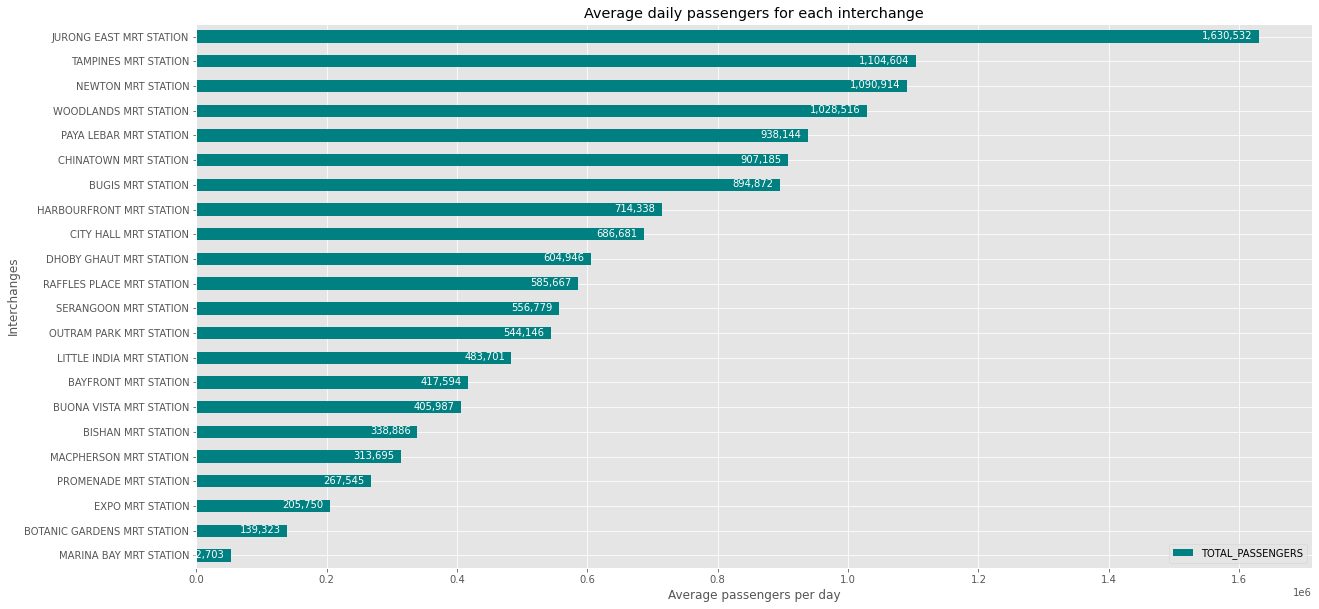

In [202]:
passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=True, inplace=True)

ax = passengers_plot.plot(kind='barh', figsize=(20, 10), x='STN_NAME', y='TOTAL_PASSENGERS', color='teal' , width=0.5 )
ax.legend( loc='lower right' )

for index, value in enumerate(passengers_plot['TOTAL_PASSENGERS']): 
    label = format(int(value), ',') # format int with commas
    
    plt.annotate(label, xy=(value - 10000, index - 0.10), color='white', ha='right' )

plt.title('Average daily passengers for each interchange')
plt.xlabel('Average passengers per day')
plt.ylabel('Interchanges')
plt.show()


#### From the above, the top 5 interchanges are
- Jurong East
- Tampines
- Newton
- Woodlands
- Paya Lebar

Update the map for these 5 locations.

In [255]:
passengers_plot.sort_values('TOTAL_PASSENGERS', ascending=False, inplace=True)
passengers_plot.reset_index(inplace=True, drop=True)
passengers_plot = passengers_plot.head(5)

top5_interchanges = mrt_interchanges_mean[ mrt_interchanges_mean['STN_NAME'].isin(passengers_plot['STN_NAME']) ].copy()
top5_interchanges.reset_index(inplace=True, drop=True)
top5_interchanges = top5_interchanges.join( passengers_plot[['TOTAL_PASSENGERS']] )

top5_interchanges


,STN_NAME,MEAN_LATITUDE,MEAN_LONGITUDE,TOTAL_PASSENGERS
0,JURONG EAST MRT STATION,1.333153,103.742311,1630532.0
1,NEWTON MRT STATION,1.312964,103.837897,1104604.0
2,PAYA LEBAR MRT STATION,1.317771,103.892604,1090914.5
3,TAMPINES MRT STATION,1.354189,103.944074,1028516.0
4,WOODLANDS MRT STATION,1.436471,103.787222,938144.5


In [292]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

num=1
# add markers to map
for lat, lng, label in zip(top5_interchanges['MEAN_LATITUDE'], top5_interchanges['MEAN_LONGITUDE'], top5_interchanges['STN_NAME']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
    num+=1

    
    
map

## 3. Getting Foursquare venues around each interchange

In [301]:
CLIENT_ID = 'QMAGZJ13AIHHQI4WPVVAIWUTRI1JUQXC0I04S3VONCLPIJ4J' # your Foursquare ID
CLIENT_SECRET = '01KL5EY4PPIWPEWFU3UB1YDAILL2EPVNZKFHYUZJKFIRONNG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QMAGZJ13AIHHQI4WPVVAIWUTRI1JUQXC0I04S3VONCLPIJ4J
CLIENT_SECRET:01KL5EY4PPIWPEWFU3UB1YDAILL2EPVNZKFHYUZJKFIRONNG


In [308]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print(venues_list)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['STN_NAME', 
                  'STN_LATITUDE', 
                  'STN_LONGITUDE', 
                  'VENUE', 
                  'VENU_LATITUDE', 
                  'VENUE_LONGITUDE', 
                  'VENUE_CATEGORY']
    
    return(nearby_venues)

In [309]:
# type your answer here
names = top5_interchanges.loc[:, 'STN_NAME']
lats = top5_interchanges.loc[:, 'MEAN_LATITUDE']
longs = top5_interchanges.loc[:, 'MEAN_LONGITUDE']

nearby_venues = getNearbyVenues( names, lats, longs)
print('DONE')

JURONG EAST MRT STATION
NEWTON MRT STATION
PAYA LEBAR MRT STATION
TAMPINES MRT STATION
WOODLANDS MRT STATION
[[('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Johan Paris', 1.334083168771419, 103.74238405765479, 'Bakery'), ('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by Ma Maison)', 1.3336684475675613, 103.74281781453568, 'Japanese Restaurant'), ('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Song Fa Bak Kut Teh 松發肉骨茶', 1.3333938719531726, 103.74341967353692, 'Chinese Restaurant'), ('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Pepper Lunch', 1.3333617653895071, 103.74308602950269, 'Japanese Restaurant'), ('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Dian Xiao Er 店小二 (Dian Xiao Er)', 1.333446950468997, 103.74309389919995, 'Chinese Restaurant'), ('JURONG EAST MRT STATION', 1.33315262, 103.7423112, 'Zaffron Kitchen', 1.3336536649052213, 103.7429579953445, 'Indian Restaurant'), ('JURONG EAST MRT STATION', 1.3331

In [310]:
nearby_venues.head()

,STN_NAME,STN_LATITUDE,STN_LONGITUDE,VENUE,VENU_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY
0,JURONG EAST MRT STATION,1.333153,103.742311,Johan Paris,1.334083,103.742384,Bakery
1,JURONG EAST MRT STATION,1.333153,103.742311,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
2,JURONG EAST MRT STATION,1.333153,103.742311,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant
3,JURONG EAST MRT STATION,1.333153,103.742311,Pepper Lunch,1.333362,103.743086,Japanese Restaurant
4,JURONG EAST MRT STATION,1.333153,103.742311,Dian Xiao Er 店小二 (Dian Xiao Er),1.333447,103.743094,Chinese Restaurant


In [315]:
map = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Stamen Terrain')

num=1
# add markers to map
for lat, lng, label in zip(nearby_venues['STN_LATITUDE'], nearby_venues['STN_LONGITUDE'], nearby_venues['STN_NAME']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
    num+=1

for lat, lng, label in zip(nearby_venues['VENU_LATITUDE'], nearby_venues['VENUE_LONGITUDE'], nearby_venues['VENUE']  ):
    label = folium.Popup( "(" + str(num) + ") " + label, parse_html=True)
  
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup= label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map)  
    
map

## Results

## Discussion

## Conclusion

In [13]:
# import pandas library 
import pandas as pd 
  
# dictionary with list object in values 
details = { 
    'Name' : ['Ankit', 'Aishwarya', 'Shaurya', 
              'Shivangi', 'Priya', 'Swapnil'], 
    'Age' : [23, 21, 22, 21, 24, 25], 
    'University' : ['BHU', 'JNU', 'DU', 'BHU',  
                    'Geu', 'Geu'], 
} 
  
# creating a Dataframe object  
df = pd.DataFrame(details, columns = ['Name', 'Age', 
                                      'University'], 
                  index = ['a', 'b', 'c', 'd', 'e', 'f']) 
  
# get names of indexes for which 
# column Age has value 21 
index_names = df[ df['Age'] == 21 ].index 
  
# # drop these row indexes 
# # from dataFrame 
# df.drop(index_names, inplace = True) 
  
# df 
index_names

Index(['b', 'd'], dtype='object')